In [1]:
import os
import os.path
import random
import math
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
import imagecodecs
from PIL import Image
import torch
from torchvision.transforms import ToTensor
from torchvision.ops import Conv2dNormActivation
import torch.nn as nn  
import torch.optim as optim
import torch.nn.functional as F
import torchbearer
from torchbearer import Trial
from torchbearer.callbacks import TensorBoard

In [2]:
DEFAULT_PATCH_SIZE = 320
def get_patches_not_random(x_dict, y_dict, size=DEFAULT_PATCH_SIZE, num_patches=800):
    x =[]
    y = []
    total_patches = 0
    print("Generating patches")
    
    for i in range(0,1):
        
        img  = x_dict[i]
        mask = y_dict[i]
        # img = list(x_dict)
        # mask = list(y_dict)
        img_height = img.shape[1]
        img_width =  img.shape[2]
        img_nb_channels = img.shape[0]
        
        mask_height = mask.shape[1]
        mask_width =  mask.shape[2]
        mask_nb_channels = mask.shape[0]
        
        device = "cuda:0"
        # while total_patches < num_patches:
        img_nb_patches_vertical = math.ceil(img_height / size)
        img_nb_patches_horizontal = math.ceil(img_width / size)
        img_extended_height = size * img_nb_patches_vertical
        img_extended_width = size * img_nb_patches_horizontal
    
        mask_nb_patches_vertical = math.ceil(mask_height / size)
        mask_nb_patches_horizontal = math.ceil(mask_width / size)
        mask_extended_height = size * mask_nb_patches_vertical
        mask_extended_width = size * mask_nb_patches_horizontal
        
        ext_x = np.zeros((img_nb_channels, img_extended_height, img_extended_width), dtype=np.float32)
        ext_y = np.zeros((mask_nb_channels, mask_extended_height, mask_extended_width), dtype=np.float32)
        ext_x[:, :img_height, :img_width] = img
        ext_y[:, :mask_height, :mask_width]  = mask
        for i in range(img_height, img_extended_height):
            mirror_i = img_height - (i - img_height) % img_height - 1
            ext_x[:, i, :] = ext_x[:, mirror_i, :]
    
        for j in range(img_width, img_extended_width):
            mirror_j = img_width - (j - img_width) % img_width - 1
            ext_x[:, :, j] = ext_x[:, :, mirror_j]
        
        for i in range(mask_height, mask_extended_height):
            mirror_i = mask_height - (i - mask_height) % mask_height - 1
            ext_y[:, i, :] = ext_y[:, mirror_i, :]
    
        for j in range(mask_width, mask_extended_width):
            mirror_j = mask_width - (j - mask_width) % mask_width - 1
            ext_y[:, :, j] = ext_y[:, :, mirror_j]  
            
        for i in range(img_nb_patches_vertical):
            for j in range(img_nb_patches_horizontal):
                x0, x1 = i * size, (i + 1) * size
                y0, y1 = j * size, (j + 1) * size
                x.append(ext_x[:, x0:x1, y0:y1])
                y.append(ext_y[:, x0:x1, y0:y1])
                total_patches += 1
        
                # print(f"generating {total_patches} patches")
        print("Generated {} patches".format(total_patches))
    
    return np.array(x, dtype= "float32"), np.array(y, dtype= "float32")               
            # print(x,y)
            # return np.array(x), np.array(y)
            # yprime=list(map(str,y))
            # new_y="".join(yprime)
            # new_y=new_y.replace("[]","")
            # new_y=list(map(int,new_y))
       
        # return torch.FloatTensor(x), torch.FloatTensor(y)
        

## Generating patches

In [3]:


"""
Returns a random augmented patch from the image

img:     numpy array of shape (x_size, y_size, nb_channels)
mask:    binary (one-hot) numpy array of shape (x_size, y_size, nb_classes)
size:    size of random patch (square)

returns: patch with shape(size, size, nb_channels) and its mask
"""

# def add_random_brightness(image, brightness_range=0.2):
#     factor = 1 + np.random.uniform(-brightness_range, brightness_range)
#     return np.clip(image * factor, 0, 255)

# def add_random_contrast(image, contrast_range=0.2):
#     mean = np.mean(image)
#     factor = 1 + np.random.uniform(-contrast_range, contrast_range)
#     return np.clip((image - mean) * factor + mean, 0, 255)

# def add_gaussian_blur(image, max_kernel_size=5):
#     if np.random.rand() < 0.5:
#         kernel_size = np.random.choice(range(1, max_kernel_size, 2))
#         image = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
#     return image

# def add_random_noise(image, noise_factor=0.05):
#     noise = np.random.randn(*image.shape) * noise_factor
#     return np.clip(image + noise, 0, 255)

def get_rand_patch(img, mask, size=DEFAULT_PATCH_SIZE):
    # assert len(img.shape) == 3     \
    #        and img.shape[0] > size \
    #        and img.shape[1] > size \
    #        and img.shape[0:2] == mask.shape[0:2]

    # SpaceNet images have 8 bands, we take only 3

    xs = random.randint(0, abs(img.shape[0] - size))
    ys = random.randint(0, abs(img.shape[1] - size))
    # print(xs,ys)
    patch_img  = img[:,xs:xs+size, ys:ys+size]
    patch_mask = mask[:,xs:xs+size, ys:ys+size]

    # # apply random transformations
    # rt = np.random.randint(0, 7)
    # if rt == 0:
    #     # horizontal flip
    #     patch_img  = patch_img[::-1, :, :]
    #     patch_mask = patch_mask[::-1, :, :]
    # elif rt == 1:
    #     # vertical flip
    #     patch_img  = patch_img[:, ::-1, :]
    #     patch_mask = patch_mask[:, ::-1, :]
    # elif rt == 2:
    #     # transpose
    #     patch_img = patch_img.transpose([1, 0, 2])
    #     patch_mask = patch_mask.transpose([1, 0, 2])
    # elif rt == 3:
    #     # 90 degree rotation
    #     patch_img = np.rot90(patch_img, 1)
    #     patch_mask = np.rot90(patch_mask, 1)
    # elif rt == 4:
    #     # 180 degree rotation
    #     patch_img = np.rot90(patch_img, 2)
    #     patch_mask = np.rot90(patch_mask, 2)
    # elif rt == 5:
    #     # 270 degree rotation
    #     patch_img = np.rot90(patch_img, 3)
    #     patch_mask = np.rot90(patch_mask, 3)
    # else:
    #     # no transformation
    #     pass
    # # if np.random.rand() < 0.5: # 50% chance to apply brightness adjustment
    #     patch_img = add_random_brightness(patch_img)

    # if np.random.rand() < 0.5: # 50% chance to apply contrast adjustment
    #     patch_img = add_random_contrast(patch_img)

    # if np.random.rand() < 0.5: # 50% chance to apply Gaussian blur
    #     patch_img = add_gaussian_blur(patch_img)

    # if np.random.rand() < 0.5: # 50% chance to apply random noise
    #     patch_img = add_random_noise(patch_img)
    
    # print(patch_img.shape, patch_mask.shape, mask.shape)
    return patch_img.tolist(), patch_mask.tolist()

In [4]:
"""
returns specified number of patches

x_dict:     (input) image dictionary (image_id -> image)
y_dict:     (output) mask dictionary (image_id -> image)
nb_pathces: number of patches to return
size:       size of patches

returns:    x and y, both numpy arrays of shape
            (nb_patches, patch_size, patch_size, nb_channels)
"""
def get_patches(x_dict, y_dict, nb_patches, size=DEFAULT_PATCH_SIZE):
    x =[]
    y = []
    total_patches = 0
    print("Generating patches")
    while total_patches < nb_patches:
        img_id = random.sample(x_dict.keys(), 1)[0]
        img  = x_dict[img_id]
        mask = y_dict[img_id]
        # img = list(x_dict)
        # mask = list(y_dict)
        img_patch, mask_patch = get_rand_patch(img, mask, size)
         
        x.append(img_patch)
        y.append(mask_patch)
        total_patches += 1
        
        # print(f"generating {total_patches} patches")
    
    print("Generated {} patches".format(total_patches))
    # print(x,y)
    # return np.array(x), np.array(y)
    # yprime=list(map(str,y))
    # new_y="".join(yprime)
    # new_y=new_y.replace("[]","")
    # new_y=list(map(int,new_y))
    return np.array(x, dtype= "float32"), np.array(y, dtype= "float32")
    # return torch.FloatTensor(x), torch.FloatTensor(y)

## U-Net model

In [5]:

""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [6]:
""" Full assembly of the parts to form the complete network """

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        out = self.softmax(logits)
        return out

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

## DeeplabV3

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

class MobileNetV3_Segmentation(nn.Module):
    def __init__(self, num_classes, input_channels=122):
        super(MobileNetV3_Segmentation, self).__init__()
        # Load the MobileNetV3 model
        mobilenet_v3 = models.mobilenet_v3_large(pretrained=True)
        
        # Modify the first convolution layer to accept input_channels
        self.features = mobilenet_v3.features
        self.features[0][0] = nn.Conv2d(input_channels, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        
        # Define the decoder part
        self.decoder = DeepLabHead(960, num_classes)  # 960 is the output channels of the last conv layer of MobileNetV3

    def forward(self, x):
        x = self.features(x)
        x = self.decoder(x)
        return x

# Define the input and output dimensions
# batch_num = 1  # Batch size
# input_channels = 122
# height = 224
# width = 224
# num_classes =   # Number of segmentation classes (including background)

# # Initialize the model
# model = MobileNetV3_Segmentation(num_classes, input_channels)

# # Test the model with a dummy input

# print(f"Logits shape: {logits.shape}")  # Shape: [batch_num, num_classes, height, width]

# # Apply softmax to get probabilities (optional, for inference purposes)
# probabilities = nn.functional.softmax(logits, dim=1)
# print(f"Probabilities shape: {probabilities.shape}")


In [ ]:
import cv2
import numpy as np
import imutils
def cut_polygon_from_image(image, points, angle):
    # Ensure we have exactly four points
    if len(points) != 4:
        raise ValueError("There must be exactly 4 points provided")
    
    # Load the image
    # image = cv2.imread(image_path)
    # if image is None:
    #     raise ValueError(f"Image not found at path: {image_path}")

    # Convert the points to a numpy array of int32 type
    pts = np.array(points, dtype="int32")

    # Create a mask with the same dimensions as the image
    mask = np.zeros(image.shape[:2], dtype=np.uint8)

    # Fill the polygon on the mask
    cv2.fillPoly(mask, [pts], 255)

    # Apply the mask to the image
    masked_image = cv2.bitwise_and(image, image, mask=mask)

    # Extract the bounding box of the polygon
    rect = cv2.boundingRect(pts)
    x, y, w, h = rect
    
    # Crop the masked image to the bounding box
    cropped_image = masked_image[y:y+h, x:x+w]
    image = imutils.rotate(cropped_image, angle=angle)
    return image

# Example usage
# image_path = "C:/Users/stdso/OneDrive/Pictures/1.jpg"
# points = [(100, 150), (480, 130), (396, 253), (120, 350)] 

# cut_image = cut_polygon_from_image(image_path, points)

# def cut_and_rotate_polygon_from_image(image, points, angle):
#     # Ensure we have exactly four points
#     if len(points) != 4:
#         raise ValueError("There must be exactly 4 points provided")
    
#     # Convert the points to a numpy array of int32 type
#     pts = np.array(points, dtype="int32")

#     # Compute the bounding box of the polygon
#     rect = cv2.minAreaRect(pts)
#     box = cv2.boxPoints(rect)
#     box = np.int0(box)

#     # Compute the center of the bounding box
#     center = (int(rect[0][0]), int(rect[0][1]))

#     # Compute the rotation matrix
#     M = cv2.getRotationMatrix2D(center, angle, 1.0)

#     # Rotate the entire image
#     rotated_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

#     # Rotate the polygon points
#     rotated_pts = cv2.transform(np.array([pts]), M)[0]

#     # Create a mask with the same dimensions as the rotated image
#     mask = np.zeros(rotated_image.shape[:2], dtype=np.uint8)

#     # Fill the polygon on the mask
#     cv2.fillPoly(mask, [rotated_pts], 255)

#     # Apply the mask to the rotated image
#     masked_image = cv2.bitwise_and(rotated_image, rotated_image, mask=mask)

#     # Extract the bounding box of the rotated polygon
#     rect = cv2.boundingRect(rotated_pts)
#     x, y, w, h = rect

#     # Crop the masked image to the bounding box
#     cropped_image = masked_image[y:y+h, x:x+w]

#     return cropped_image

In [8]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Example: Let's assume 'image' is a 3D numpy array with shape (height, width, 122)

def reduce_channels(image, n_components=30):
    num_channels, height, width= image.shape
    assert num_channels == 122, "The input image must have 122 channels"

    # Step 1: Flatten the image channels
    flattened_image = image.reshape(-1, num_channels)
    
    # Step 2: Standardize the data
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(flattened_image)
    
    # Step 3: Apply PCA
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(standardized_data)
    
    # Step 4: Reshape the data back to image shape
    reduced_image = reduced_data.reshape(n_components, height, width)
    
    return reduced_image

# Example usage with a mock image
# image = np.random.rand(100, 100, 122)  # Replace with the actual image
# reduced_image = reduce_channels(image, n_components=30)

# If you have a specific image, load it and apply the function
# For example, using OpenCV to read an image:
# import cv2
# image = cv2.imread('path_to_image')  # This needs to be replaced with actual image loading
# reduced_image = reduce_channels(image, n_components=30)

In [9]:
# def normalize(img):
#     # minv = img.min()
#     maxv = img.max()
#     print(maxv)
#     return img / maxv
img_dict = {}
mask_dict = {}
def normalize(img):
    """this function normalize the pixels in range (0,1)"""
    min = img.min()
    max = img.max()
    x = 1/(max-min)
    img = (img-min)*x
    return img

In [22]:
# corners = [(3428.260869565217, 0.0), (4463.043478260869, 1440.8478260869567), (1436.9565217391305, 3419.108695652174), (345.6521739130435, 1962.5869565217392)]
# for i in range(1,3):
i = 0 
img = normalize(tiff.imread(f'train4.tif'))
mask = tiff.imread("label4.tif")
# print(img, mask)
img_list= []
mask_list= []
for j in range(img.shape[0]):
    # cropped_img = transform_image(img[i], corners)
    # cropped_img = cut_polygon_from_image(img[j], corners, 57)
    img_list.append(img)
# tiff.imwrite('train1_cropped.tif', np.array(img_list))

for k in range(mask.shape[0]):
    # cropped_mask =cut_polygon_from_image(mask[k],corners, 57)
    mask_list.append(mask)
img_dict[i] = np.array(img_list)
mask_dict[i] = np.array(mask_list)
    # img_dict[i] = cropped_img
    # mask_dict[i] = cropped_mask
# tiff.imwrite('label1_cropped.tif', np.array(mask_list))

MemoryError: Unable to allocate 543. GiB for an array with shape (122, 122, 2750, 1780) and data type float64

In [10]:
img = tiff.imread('/storage/student5/xuan_quy/HSI/train4.tif')
mask = tiff.imread('/storage/student5/xuan_quy/HSI/label4.tif')
# print(image.shape, mask.shape)


In [ ]:
# i = 1 
# img = normalize(tiff.imread(f'datas/image/train{i+1}.tif'))
# mask = tiff.imread(f"datas/label/test{i+1}.tif")
# # print(img, mask)
# corners = [(4577.5, 1469.3333333333333), (5585.833333333334, 2952.666666666667), (2277.5, 5127.666666666667), (1094.166666666667, 3577.666666666667)]
# img_list= []
# mask_list= []
# for j in range(img.shape[0]):
#     # cropped_img = transform_image(img[i], corners)
#     cropped_img = cut_polygon_from_image(img[j], corners, 57)
#     img_list.append(cropped_img)
# # tiff.imwrite('train1_cropped.tif', np.array(img_list))

# for k in range(mask.shape[0]):
#     cropped_mask =cut_polygon_from_image(mask[k],corners, 57)
#     mask_list.append(cropped_mask)

# # img = np.array(img_list)
# img_dict[i] = np.array(img_list)
# mask_dict[i] = np.array(mask_list)

255


In [ ]:
# i = 2 
# img = normalize(tiff.imread(f'datas/image/train{i+1}.tif'))
# mask = tiff.imread(f"datas/label/test{i+1}.tif")
# # print(img, mask)
# corners = [(4880.962962962963, 1596.2962962962963), (6269.851851851851,2774.074074074074), (3282.7058823529414, 7029.14705882353), (1788.588235294118,
#           5923.264705882353)]
# img_list= []
# mask_list= []
# for j in range(img.shape[0]):
#     # cropped_img = transform_image(img[i], corners)
#     cropped_img = cut_polygon_from_image(img[j], corners, 37)
#     img_list.append(cropped_img)
# # tiff.imwrite('train1_cropped.tif', np.array(img_list))

# for k in range(mask.shape[0]):
#     cropped_mask =cut_polygon_from_image(mask[k],corners, 37)
#     mask_list.append(cropped_mask)

# img_dict[i] = np.array(img_list)
# mask_dict[i] = np.array(mask_list)

In [ ]:
# i = 3 
# img = normalize(tiff.imread(f'datas/image/train{i+1}.tif'))
# mask = tiff.imread(f"datas/label/test{i+1}.tif")
# # print(img, mask)
# corners = [(4296.296296296296, 1566.6296296296296), (5693.736842105263, 2710.5263157894738), (2656.8947368421054, 7063.157894736842), (1120.0526315789475, 5984.210526315789)]
# img_list= []
# mask_list= []
# for j in range(img.shape[0]):
#     # cropped_img = transform_image(img[i], corners)
#     cropped_img = cut_polygon_from_image(img[j], corners, 37)
#     img_list.append(cropped_img)
# # tiff.imwrite('train1_cropped.tif', np.array(img_list))

# for k in range(mask.shape[0]):
#     cropped_mask =cut_polygon_from_image(mask[k],corners, 37)
#     mask_list.append(cropped_mask)

# img_dict[i] = np.array(img_list)
# mask_dict[i] = np.array(mask_list)

In [ ]:
# tiff.imshow(img_dict[0][89])
i = 0 
# img = np.array(img_dict[i])
# mask = np.array(mask_dict[i])

# cropped_imgs_dict = {}
# cropped_masks_dict = {}
# cropped_imgs = []
# cropped_masks = []
# for k in range(img.shape[0]):
#     cropped_image = img[k][:, 1150:2950]
#     cropped_imgs.append(cropped_image)
# # tiff.imshow(np.array(cropped_imgs[89]))
# for j in range(mask.shape[0]):
#     cropped_masked = mask[j][:, 1150:2950]
#     cropped_masks.append(cropped_masked)
 
# img = np.array(cropped_imgs)
pca_img = reduce_channels(img, n_components=30)
cropped_imgs_dict[i] = pca_img
# cropped_imgs_dict[i] = np.array(cropped_imgs)
cropped_masks_dict[i] = np.array(cropped_masks)

# tiff.imshow((cropped_imgs_dict[0][89]))  

In [ ]:
print(cropped_imgs_dict[0].shape)

(30, 3420, 1800)


In [11]:
# tiff.imshow(img_dict[1][89])
# print(img_dict[0].shape)
i = 0
# img = np.array(img_dict[i])
# mask = np.array(mask_dict[i])
# cropped_imgs = []
# cropped_masks = []
# for k in range(img.shape[0]):
#     cropped_image = img[k][:, 1350:3200]
#     cropped_imgs.append(cropped_image)
# tiff.imshow(np.array(cropped_imgs[89]))
# for j in range(mask.shape[0]):
#     cropped_masked = mask[j][:, 1350:3200]
#     cropped_masks.append(cropped_masked)
# tiff.imshow(np.array(cropped_masks[0]))   

# img = np.array(cropped_imgs)
pca_img = reduce_channels(img, n_components=30)
# cropped_imgs_dict[i] = pca_img
# cropped_masks_dict[i] = np.array(cropped_masks)

In [ ]:
print(cropped_imgs_dict[1].shape)

(30, 3659, 1850)


In [ ]:
# tiff.imshow(img_dict[2][89])
# i = 2 
# img = np.array(img_dict[i])
# mask = np.array(mask_dict[i])
# cropped_imgs = []
# cropped_masks = []
# for k in range(img.shape[0]):
#     cropped_image = img[k][:, 1400:3100]
#     cropped_imgs.append(cropped_image)
# tiff.imshow(np.array(cropped_imgs[89]))
# for j in range(mask.shape[0]):
#     cropped_masked = mask[j][:, 1400:3100]
#     cropped_masks.append(cropped_masked)
# tiff.imshow(np.array(cropped_masks[0]))   

# cropped_imgs_dict[i] = np.array(cropped_imgs)
# cropped_masks_dict[i] = np.array(cropped_masks)

In [ ]:
# tiff.imshow(img_dict[3][89])
# i = 3 
# img = np.array(img_dict[i])
# mask = np.array(mask_dict[i])
# cropped_imgs = []
# cropped_masks = []
# for k in range(img.shape[0]):
#     cropped_image = img[k][:, 1400:3100]
#     cropped_imgs.append(cropped_image)
# tiff.imshow(np.array(cropped_imgs[89]))
# for j in range(mask.shape[0]):
#     cropped_masked = mask[j][:, 1400:3100]
#     cropped_masks.append(cropped_masked)
# tiff.imshow(np.array(cropped_masks[0]))   

# cropped_imgs_dict[i] = np.array(cropped_imgs)
# cropped_masks_dict[i] = np.array(cropped_masks)

In [ ]:
print(cropped_masks_dict[0].shape)


(3, 3420, 1800)


## Training

In [12]:
X_TRAIN = {}
Y_TRAIN = {}
X_VAL = {}
Y_VAL = {}
X_TEST = {}
Y_TEST = {}

# print(cropped_imgs_dict[i].shape)

img = pca_img

height = img.shape[1]
width = img.shape[2]

train_height = int(height*0.7)
val_height = int(height*0.1)
test_height = int(height* 0.2)

#create dummy array for dividing the train, validate and test set
train_img = np.zeros([img.shape[0], train_height, width])
val_img = np.zeros([img.shape[0], val_height, width])
test_img = np.zeros([img.shape[0], test_height, width])



train_mask = np.zeros([img.shape[0], train_height, width])
val_mask = np.zeros([img.shape[0], val_height, width])
test_mask = np.zeros([img.shape[0], test_height, width])

train_img = img[:, 0:train_height, 0:width]
X_TRAIN[i] = train_img
val_img = img[:, train_height:train_height+val_height, 0:width]
X_VAL[i] = val_img
test_img = img[:,train_height+val_height:height, 0:width]
X_TEST[i] = test_img

train_mask = mask[:, 0:train_height, 0:width]
Y_TRAIN[i] = train_mask
val_mask = mask[:, train_height:train_height+val_height, 0:width]
Y_VAL[i] = val_mask
test_mask = mask[:,train_height+val_height:height, 0:width]
Y_TEST[i] = test_mask

In [13]:
print(Y_TRAIN[0].shape)
print(Y_VAL[0].shape)
print(Y_TEST[0].shape)

(3, 1924, 1780)
(3, 275, 1780)
(3, 551, 1780)


In [14]:
"""
returns image normalized to be in [-1, 1]
"""
NB_BANDS      = 30
NB_CLASSES    = 3   
CLASS_WEIGHTS = [2, 1, 1]
NB_EPOCHS     = 1000
BATCH_SIZE    = 8
UPCONV        = True
PATCH_SIZE    = 224 # should be divisible by 16
NB_TRAIN      = 800
NB_VAL        = 200
LEARNING_RATE =0.001



In [15]:
x_train, y_train = get_patches_not_random(X_TRAIN, Y_TRAIN, PATCH_SIZE, num_patches=400)
print('Done generate train patches')
x_val, y_val = get_patches_not_random(X_VAL, Y_VAL, PATCH_SIZE, num_patches=100)
print('Done generate validate patches')
x_test, y_test = get_patches_not_random(X_TEST, Y_TEST, PATCH_SIZE, num_patches=100)
print('Done generate test patches')
np.save('x_train.npy', x_train)
np.save('y_train.npy', y_train)
np.save('x_val.npy', x_val)
np.save('y_val.npy', y_val)
np.save('x_test.npy', x_test)
np.save('y_test.npy', y_test)


Generating patches
Generated 72 patches
Done generate train patches
Generating patches
Generated 16 patches
Done generate validate patches
Generating patches
Generated 24 patches
Done generate test patches


In [17]:
def train_net(model, device,  x_train, y_train, x_val, y_val):
    print("Training network")
    # x_train, y_train = get_patches(X_DICT_TRAIN, Y_DICT_TRAIN, NB_TRAIN, PATCH_SIZE)
    
    # x_val, y_val = get_patches(X_DICT_VAL, Y_DICT_VAL, NB_VAL, PATCH_SIZE)
    # print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
    # y_train = np.where(y_train > 8, 255, 0)
    # y_val = np.where(y_val > 5, 255, 0)
    # u, c = np.unique(y_val, return_counts=True)
    # dup = u[c > 1]
    # print(dup)
    train_losses = []
    val_losses = []

    train_dat = torch.utils.data.TensorDataset(torch.cuda.FloatTensor(x_train), torch.cuda.FloatTensor(y_train))
    train_loader = torch.utils.data.DataLoader(train_dat, batch_size=BATCH_SIZE, shuffle=True)
    val_dat = torch.utils.data.TensorDataset(torch.cuda.FloatTensor(x_val), torch.cuda.FloatTensor(y_val))
    val_loader = torch.utils.data.DataLoader(val_dat, batch_size=BATCH_SIZE, shuffle=False)  # No need to shuffle
                
     
    # model = UNet(num_classes=3, in_channels=122, depth=6, merge_mode='concat').to(device)
    # model = UNet(num_classes=3).to(device)
    criterion = nn.CrossEntropyLoss(weight=torch.cuda.FloatTensor(CLASS_WEIGHTS))
    # criterion = nn.BCEWithLogitsLoss(pos_weight=torch.cuda.FloatTensor(CLASS_WEIGHTS))
    # criterion = nn.BCELoss(weight=torch.cuda.FloatTensor(CLASS_WEIGHTS))
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = NB_EPOCHS
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            # softmax = nn.Softmax(dim=1)
            # targets = softmax(targets)
            
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += (loss.item() * inputs.size(0))
            train_losses.append(train_loss)
            #print(f'Training Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
                
        # Validation phase

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                outputs = model(inputs)
                
                loss = criterion(outputs, targets)
                
                val_loss += loss.item() * inputs.size(0)
        
        # Average losses
        train_loss = train_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss {val_loss:.4f}')
        val_losses.append(val_loss)
    torch.save(model.state_dict(), 'unet_model.pth')
    print("Training done")
    return train_losses, val_losses, x_train, y_train

Training network


/tmp/ipykernel_415691/1895911190.py:15: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  train_dat = torch.utils.data.TensorDataset(torch.cuda.FloatTensor(x_train), torch.cuda.FloatTensor(y_train))


Epoch [1/1000], Training Loss: 300.6138, Validation Loss 295.4893
Epoch [2/1000], Training Loss: 286.8905, Validation Loss 273.1238
Epoch [3/1000], Training Loss: 282.4315, Validation Loss 258.2150
Epoch [4/1000], Training Loss: 280.0288, Validation Loss 249.6071
Epoch [5/1000], Training Loss: 278.4540, Validation Loss 249.4802
Epoch [6/1000], Training Loss: 278.1273, Validation Loss 249.3383
Epoch [7/1000], Training Loss: 276.9488, Validation Loss 252.9566
Epoch [8/1000], Training Loss: 276.3560, Validation Loss 258.0451
Epoch [9/1000], Training Loss: 273.6879, Validation Loss 249.1575
Epoch [10/1000], Training Loss: 272.2593, Validation Loss 238.5300
Epoch [11/1000], Training Loss: 272.2591, Validation Loss 235.1357
Epoch [12/1000], Training Loss: 270.9604, Validation Loss 230.4732
Epoch [13/1000], Training Loss: 270.3853, Validation Loss 232.7578
Epoch [14/1000], Training Loss: 269.5130, Validation Loss 236.3014
Epoch [15/1000], Training Loss: 268.3335, Validation Loss 243.3201
Epoc

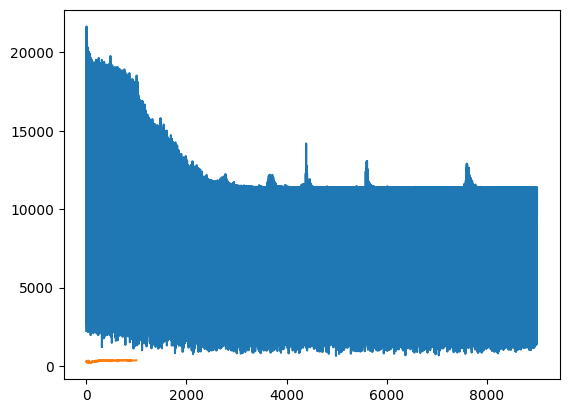

In [18]:
x_train = np.load('x_train.npy')
x_val = np.load('x_val.npy')
y_train = np.load('y_train.npy')
y_val =np.load('y_val.npy')

# print(x_train.shape)
torch.cuda.set_device(3)
device = "cuda:3"
model= UNet(NB_BANDS, NB_CLASSES).to(device) 
train_losses, val_losses, x_train, y_train = train_net(model, device, x_train, y_train, x_val, y_val)
# print(x_train)
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

In [19]:
#save model
torch.save(model.state_dict(), 'unet_model.pth')

## Predicting

In [16]:
NB_BANDS      = 30
NB_CLASSES    = 3   
# CLASS_WEIGHTS = [2, 1, 1]
NB_EPOCHS     = 100
BATCH_SIZE    = 8
UPCONV        = True
PATCH_SIZE    = 224  # should be divisible by 16
NB_TRAIN      = 800
NB_VAL        = 200
NB_TEST       = 200

data_path = "datas"
weight_path = 'weights'

# def normalize(img):
#     minv = img.min()
#     maxv = img.max()
#     return 2.0 * (img - minv) / (maxv - minv) - 1.0


In [17]:
def predict(x, model, patch_size=320, nb_classes=3):
    img_height = x.shape[1]
    img_width =  x.shape[2]
    nb_channels = x.shape[0]
    device = "cuda:3"
    
    nb_patches_vertical = math.ceil(img_height / patch_size)
    nb_patches_horizontal = math.ceil(img_width / patch_size)
    extended_height = patch_size * nb_patches_vertical
    extended_width = patch_size * nb_patches_horizontal
    ext_x = np.zeros((nb_channels, extended_height, extended_width), dtype=np.float32)

    ext_x[:, :img_height, :img_width] = x
    for i in range(img_height, extended_height):
        mirror_i = img_height - (i - img_height) % img_height - 1
        ext_x[:, i, :] = ext_x[:, mirror_i, :]

    for j in range(img_width, extended_width):
        mirror_j = img_width - (j - img_width) % img_width - 1
        ext_x[:, :, j] = ext_x[:, :, mirror_j]

    patches_list = []
    predictions_list = []
    predicted_classes_list = []

    # for i in range(nb_patches_vertical):
    #     for j in range(nb_patches_horizontal):
    #         x0, x1 = i * patch_size, (i + 1) * patch_size
    #         y0, y1 = j * patch_size, (j + 1) * patch_size
    #         patches_list.append(ext_x[:, x0:x1, y0:y1])
    #         # if len(patches_list) == 1000:
    #         #     print(patches_list)
    #             patches_np = np.array(patches_list)
    #             patches = torch.Tensor(patches_list).to(device)
                
    #             model.eval()
    #             with torch.no_grad():
    #                 prediction = model(patches).to(device)
    #                 # predicted_class = torch.argmax(prediction)
                
    #             predictions_list.append(prediction.detach().cpu().numpy())
    #             # predicted_classes_list.append(predicted_class.detach().cpu().numpy())
    #             patches_list.clear()
    #             torch.cuda.empty_cache()

    # if patches_list:
    #     patches_np = np.array(patches_list)
    #     patches = torch.Tensor(patches_list).to(device)
        
    # model.eval()
    # with torch.no_grad():
    #     prediction = model(patches).to(device)
    #     predicted_class = torch.argmax(prediction)
        
    # predictions_list.append(prediction.detach().cpu().numpy())
    # # predicted_classes_list.append(predicted_class.detach().cpu().numpy())
    # torch.cuda.empty_cache()

    # predictions = np.concatenate(predictions_list, axis=0)
    # # predicted_classes = np.concatenate(predicted_classes_list, axis=0)

    # return prediction.detach().cpu().numpy()

    for i in range(nb_patches_vertical):
        for j in range(nb_patches_horizontal):
            x0, x1 = i * patch_size, (i + 1) * patch_size
            y0, y1 = j * patch_size, (j + 1) * patch_size
            patches_list.append(ext_x[:, x0:x1, y0:y1])

    patches = torch.Tensor(patches_list).to(device)
    print(patches.shape)
    model.eval()
    prediction = model(patches)
    # predicted_class = torch.argmax(prediction)

    return prediction.detach().cpu().numpy()
    
device = 'cuda:3'    
model= UNet(NB_BANDS, NB_CLASSES).to(device)  
# model = UNet(num_classes=3, in_channels=122, depth=6, merge_mode='concat').to(device)   
# model = UNet(num_classes=3).to(device)
id = 1
model.load_state_dict(torch.load('unet_model.pth'))
model.to(device)
predictions = predict(X_TEST[0], model, PATCH_SIZE, 3)

/tmp/ipykernel_418118/2584464002.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('unet_model.pth'))
/tmp/ipykernel_418118/2584464002.py

torch.Size([24, 30, 224, 224])


In [18]:
predictions[0,0,0,0] + predictions[0,1,0,0] + predictions[0,2,0,0]

1.0

In [19]:
"""
returns an RGB image with color-coded classes based on mask

mask: mask of shape (height, width, nb_classes)
"""
def picture_from_mask(mask, threshold=0):
    colors = {
        0: [0, 0, 255], 
        1: [255, 0, 0],   
        2: [0, 255, 0],     
    }
    z_order = {
        1: 0,
        2: 1,
        3: 2,
    }

    pict = 255 * np.ones((3, mask.shape[1], mask.shape[2]), dtype=np.uint8)
    for i in range(1, 4):
        cl = z_order[i]
        for ch in range(3):
            pict[ch, :, :][mask[cl, :, :] > threshold] = colors[cl][ch]
    return pict

def plot_images(images, num_cols=4):
    num_images = images.shape[0]
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            ax.imshow(images[i].transpose(1, 2, 0))  # Transpose to (height, width, channels)
            ax.axis('off')
        else:
            ax.axis('off')  # Hide axes for empty subplots

    plt.show()

def get_color_map(mask, threshold):
    mask = np.abs(mask)
    deficient = np.where(mask[0] > threshold, 1, 0)
    sufficient = np.where(mask[1] > 0.5, 1, 0)
    excessive = np.where(mask[2] > 0.124, 1, 0)
    return deficient, sufficient, excessive

In [20]:
# predictions = predictions.transpose(0, 3, 2, 1)
preds = predictions
print(preds.shape)
# print(preds_class)
img_height = test_img.shape[1]
img_width =  test_img.shape[2]
nb_channels = test_img.shape[0]

nb_patches_vertical = math.ceil(img_height / PATCH_SIZE)
nb_patches_horizontal = math.ceil(img_width / PATCH_SIZE)
extended_height = PATCH_SIZE * nb_patches_vertical
extended_width = PATCH_SIZE * nb_patches_horizontal
ext_x = np.zeros((nb_channels, extended_height, extended_width), dtype=np.float32)

    # model.predict() requires a numpy array
np_predictions = np.zeros((3,extended_height, extended_width), dtype=np.float32)
count = 0 
for k in range(preds.shape[0]):
    # print(preds[k].shape)
    # count += 1 
    i = k // nb_patches_horizontal  # Corrected: vertical index
    j = k % nb_patches_horizontal   # Corrected: horizontal index
    x0, x1 = i * PATCH_SIZE, (i + 1) * PATCH_SIZE
    y0, y1 = j * PATCH_SIZE, (j + 1) * PATCH_SIZE
    # print(x0, x1, y0, y1)
    # print(count)
    # print(np_predictions.shape)
    np_predictions[:, x0:x1, y0:y1] = preds[k]
final_predictions = np_predictions[:, :img_height, :img_width]
# final_predictions = finals.transpose([1,2,0])
# print(final_predictions.shape, test_mask.shape)
print(f"predictions: {final_predictions[0]}")
print(f"labels: {Y_TEST[0]}")
# plt.imshow(np.abs(255*(final_predictions)).astype('uint8'))
# print(preds)
# u, c = np.unique(test_mask[1], return_counts=True)
# print(dup)
# print(np.abs(final_predictions[0]))
# print(test_mask[2])
map_ = picture_from_mask(final_predictions, 0.2)
class1, class2, class3 = get_color_map(final_predictions, 0.7)
# print(class1)
# print(class2)
# print(np.min(final_predictions[0]))
# print(map_[2])
# tiff.imwrite('class1.tif', class1)
# # tiff.imwrite('map.tif',map_)
# tiff.imwrite('result.tif', (255*(final_predictions)).astype('uint8'))
# tiff.imwrite('y_test.tif', test_mask)


(24, 3, 224, 224)
predictions: [[1.5254624e-03 1.3771344e-03 1.3206626e-03 ... 1.0000000e+00
  9.9999988e-01 9.9999988e-01]
 [4.4807611e-04 3.3171690e-04 3.4483543e-04 ... 1.0000000e+00
  1.0000000e+00 1.0000000e+00]
 [6.3128922e-05 2.3789920e-05 2.1519640e-05 ... 1.0000000e+00
  1.0000000e+00 1.0000000e+00]
 ...
 [8.0745034e-05 7.6473434e-06 2.0294547e-06 ... 2.5201298e-06
  4.7619114e-06 1.1113195e-05]
 [9.9767181e-05 9.1504062e-06 2.1200622e-06 ... 3.6218605e-06
  6.2448453e-06 1.4530690e-05]
 [5.9507831e-05 4.8669731e-06 1.5187954e-06 ... 2.6779708e-06
  5.7032184e-06 1.2179824e-05]]
labels: [[[  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  ...
  [  0   0   0 ... 255 255 255]
  [  0   0   0 ... 255 255 255]
  [  0   0   0 ... 255 255 255]]

 [[  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  ...
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]

In [25]:
print(final_predictions.shape)

(3, 551, 1780)


In [21]:
def findmax(a,b,c):
    if (a>b) and (a>c):
        return a
    elif (b>a) and (b>c):
        return b
    else:
        return c 

In [22]:
predictions = np.zeros([final_predictions.shape[0], final_predictions.shape[1], final_predictions.shape[2]], dtype=np.float32)
for i in range(final_predictions.shape[2]):
    for j in range(final_predictions.shape[1]):
        max = findmax(final_predictions[0,j,i],final_predictions[1,j,i],final_predictions[2,j,i])
        if max == final_predictions[0,j,i]:
            predictions[0,j,i] = 1
            predictions[1,j,i] = 0
            predictions[2,j,i] = 0

        elif max == final_predictions[1,j,i]:
            predictions[1,j,i] = 1
            predictions[0,j,i] = 0
            predictions[2,j,i] = 0   

        elif max == final_predictions[2,j,i]:
            predictions[2,j,i] = 1 
            predictions[1,j,i] = 0
            predictions[0,j,i] = 0

In [28]:
# print(f"predictions: {predictions}")                
# print(f"test mask: {Y_TEST[0]}")
# # for i in range (3):
#     for j in range(725):
#         accuracy_score(predictions[i], test_mask[i])
#         print(accuracy_score)

(<Figure size 988.8x604.8 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f27381a7560>)

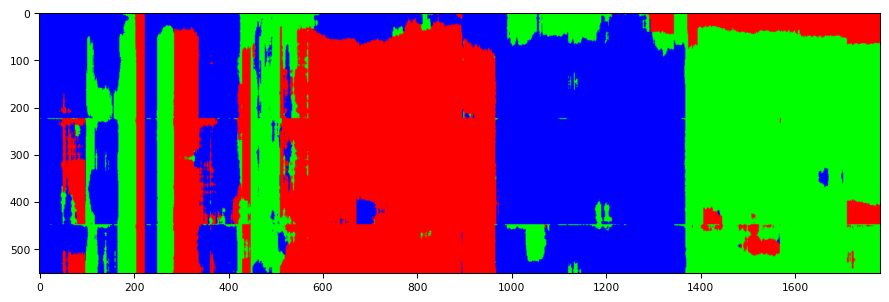

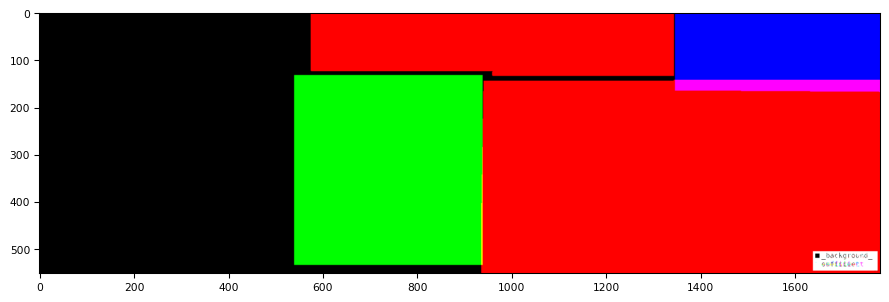

In [24]:
# label = tiff.imread('y_test.tif')
# map = tiff.imread('map.tif')
# result = tiff.imread('result.tif')

tiff.imshow(255*(predictions).astype('uint8'))
tiff.imshow(Y_TEST[0])
# tiff.imwriet('test',test_img)
# tiff.imwrite('prediction2.tif',255*(predictions).astype('uint8'))

# tiff.imshow(CR)
# tiff.imshow(result)
# tiff.imshow(map)
# tiff.imshow(label)